![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&file=BQML+Multivariate+Forecasting+with+ARIMA%2B+XREG.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BQML%20Multivariate%20Forecasting%20with%20ARIMA%2B%20XREG.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>在Colab中运行
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Forecasting%2FBQML%2520Multivariate%2520Forecasting%2520with%2520ARIMA%252B%2520XREG.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>在Colab企业版中运行
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BQML%20Multivariate%20Forecasting%20with%20ARIMA%2B%20XREG.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>在GitHub上查看
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Forecasting/BQML%20Multivariate%20Forecasting%20with%20ARIMA%2B%20XREG.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>在Vertex AI Workbench中打开
    </a>
  </td>
</table>

待办事项清单 随着模型类型从[预览到GA](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-multivariate-time-series):
- [ ] 将结果与单变量进行比较
- [ ] 添加单变量作为预备条件，然后解析结果以选择多变量系列
- [ ] 随着功能的推出保持待办事项清单:
    - [ ] 使用`time_series_id_col`的多个时间序列
        - 在本笔记本的结尾提出的解决方法
    - [X] 解释
    - [ ] 使用`ml.detect_anomalies`检测异常

# BigQuery ML (BQML) - 包括外部回归变量的Multivariate Forecasting with ARIMA+

在本笔记本中，我们对在[准备笔记本](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)中审查和准备的数据进行了预测模型的拟合 - 纽约市中央公园附近的citibike自行车租赁站每日租车量。在这次尝试中，我们通过使用BigQuery内置的机器学习（通常称为BQML）将预测活动保持在数据仓库内。可用的模型类型之一是ARIMA+ XREG（`model_type ='ARIMA_PLUS_XREG'`）。这通过使用自回归集成移动平均（ARIMA）模型拟合多变量预测，同时还自动处理许多所需的数据预处理和后处理步骤，并包括时间变化协变量和线性回归器。通过将车站名称作为`start_station_name`提供给输入参数`time_series_id_col`（**目前尚未可用，`WHERE`子句用于限制数据为单个站点，本笔记本的结尾展示了解决方法**），每个站点将被单独预测。将使用各种提供的度量标准评估预测结果，我们将使用SQL计算自定义指标。甚至可以使用BigQuery ML的`ML.DETECT_ANOMALIES`函数识别异常。

**带有线性外部回归器的MULTIVARIATE预测ARIMA+**

可用的模型类型之一是带有线性外部回归器的ARIMA+（`model_type ='ARIMA_PLUS_XREG'`）。这通过使用时间变化协变量作为线性外部回归器拟合多变量预测。这是ARIMA+单变量预测的扩展，其中包含额外信息可以提高预测的准确性。来自协变量的线性回归权重将与ARIMA预测聚合。

**带有ARIMA+的UNIVARIATE预测**

可以直接使用具有ARIMA+的单变量预测（`model_type ='ARIMA_PLUS'`）。这通过使用自回归集成移动平均（ARIMA）模型拟合单变量预测，同时还自动处理许多所需的数据预处理和后处理步骤。可以使用各种提供的度量标准评估预测结果，甚至使用SQL计算自定义指标。还可以使用BigQuery ML识别异常，方法是使用`ML.DETECT_ANOMALIES`函数。此模型类型在笔记本[BQML带ARIMA+的单变量预测](./BQML%20Univariate%20Forecasting%20with%20ARIMA+.ipynb)中进行拟合。

**ARIMA+**

ARIMA是一个时间序列数据的统计模型，有助于理解模式并预测未来的时间点。该模型由三部分组成:
- AR，自回归。指示一个变量根据其自身的先前值进行回归。
    - `p`，指示考虑的滞后数或先前时间点的数量的参数
- I，积分。指示值已替换为值与上一个值之间的差值。
    - `d`，指示差分程度或数据已过去值减去的次数
- MA，移动平均。指示回归误差是过去各个时间点的值的组合。
    - `q`，指示移动平均阶数的参数

参考：
- [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

## Colab设置

要在Colab中运行此笔记本，请点击 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BQML%20Multivariate%20Forecasting%20with%20ARIMA%2B%20XREG.ipynb) 并运行此部分中的单元格。否则，请跳过此部分。

此单元格将向GCP进行身份验证（请按照弹出窗口中的提示进行操作）。

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [473]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

安装和API启用

客户端包可能需要在这个环境中安装。

### 安装（如有需要）

In [4]:
# tuples of (import name, install name)
packages = [
    ('plotly', 'plotly'),
    ('kaleido', 'kaleido')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### 重新启动内核（如果发生安装）

内核重新启动后，代码提交可以从此单元格之后的下一个单元格开始。

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

设置

输入:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'bqml-arimaplusxreg'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

viz_limit = 12

包裹:

In [3]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

客户:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)

## 时间序列审查

**单变量预测** 每个时间序列仅包含2列：
- `TARGET_COLUMN` = 需求量测。
    在我们的情况下，它是从特定自行车站每天出发的行程数量 - 当天的行程总和。
- `TIME_COLUMN` = 需求的时间。
    以与预测练习的粒度相关的时间或日期单位表示。在我们的情况下，需求是每天测量的，所以时间列准备为日期。

**附加列** 用于指导预测算法处理数据：
- `SERIES_COLUMN` 将与同一时间序列相关的行进行分组。
    - 进行多个预测，每个时间序列一个意味着要包括第三列来捕获每个时间序列的行组：`SERIES_COLUMN`。
    - **注意：** BigQuery ARIMA+ 为每个时间序列拟合单独的预测。
- `SPLITS_COLUMN` 将每个时间序列内的连续行分组，以便在预测练习中使用。
    - 这些数据在预备笔记本中使用 `TRAIN`、 `VALIDATE` 和 `TEST` 进行了拆分。包含这些拆分的列可以在训练过程中被选择的预测方法使用，而无需让方法计算拆分。这在比较多种不同方法时很有帮助，因为它确保每种方法在拆分上的处理方式是相同的。
- `COVARIATE_COLUMNS` 是衡量额外特征随时间变化的列的列表。一些预测方法可以使用这些列来改善对趋势的理解，从而做出更好的预测。单变量预测方法不会使用这些列。要用协变量进行预测，其值需要在预测时已知以用于做出预测，或者预测方法需要对未知协变量有特殊处理。协变量信息可以有三种类型：
    - 属性
        - 不随时间改变的值，但描述时间序列表示的内容。在我们的情况下，自行车站可能通过纬度和经度、颜色、单车插槽数量来确定。
    - 预测时可用的协变量
        - 可以提前知道的测量数据，例如节假日、促销活动、事件、容量变化。
    - 在预测时不可用的协变量
        - 随时间变化但直到测量时才知道的测量数据，例如雨天、其他天气情况、行人流量和排队长度。

**预测参数**：
- `FORECAST_GRANULARITY` 是测量频率，如分钟、小时、天、周、月、年
    - 数据在数据准备笔记本中以天为单位进行了汇总。
    - 这是测量之间的时间量 - 行数。
    - 对于不同的粒度，您可能需要将需求信号汇总为不同时间部分的 `SUM`、 `MIN`、 `MAX` 或 `AVERAGE`。
    - 粒度的具体规范因方法而异：
        - BigQuery ML: PER_MINUTE、HOURLY、DAILY、WEEKLY、MONTHLY、QUARTERLY、YEARLY
        - Prophet（包括 Vertex Pre-Built Pipelines）: 分钟、小时、天、周、月或年
        - Vertex AI AutoML: 分钟、小时、天、周、月、年
    - 用于提取时间和日期组件的非常有用的 BigQuery 函数是 `EXTRACT` 函数：
        - [作为日期函数的 EXTRACT](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)
        - [作为时间函数的 EXTRACT](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#extract)
        - [作为日期时间函数的 EXTRACT](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions#extract)。
- `FORECAST_TEST_LENGTH` 是分配给测试区域的行数
    - 这是以 `FORECAST_GRANULARITY` 为单位的。
    - 数据准备包括设置这个值以指定每个时间序列中的`SERIES_COLUMN`的 `SPLITS_COLUMN = 'TEST'` 值。
- `FORCAST_VALIDATE_LENGTH` 是分配给验证区域的行数
    - 这是以 `FORECAST_GRANULARITY` 为单位的。
    - 数据准备包括设置这个值以指定每个时间序列中的 `SERIES_COLUMN` 的 `SPLITS_COLUMN = 'VALIDATE'` 值。
- `FORECAST_HORIZON_LENGTH` 是预测未来超出测试区域的行数
    - 这是以 `FORECAST_GRANULARITY` 为单位的。
    - 这需要作为预测方法的输入进行设置。

In [5]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

# CUSTOMIZE
FORECAST_GRANULARITY = 'DAILY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

检索分割的关键日期:

In [6]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

检索原始数据。

In [7]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

注意：在初始发布期间

只有一个系列被预测，因为尚未提供`time_series_id_col`参数。这本笔记本选择的`start_station`值是：'Central Park S & 6 Ave'。

要进行多个预测，可以在本笔记本底部展示几种解决方法。

In [8]:
chosen_station = 'Central Park S & 6 Ave'
rawSeries = rawSeries[rawSeries[SERIES_COLUMN]==chosen_station]

### 画时间序列 - 叠加协变量

使用[Plotly](https://plotly.com/python/)创建一个交互式图表，以查看单个时间序列（自行车站）并通过滚动时间范围来查看。

In [9]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] + COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


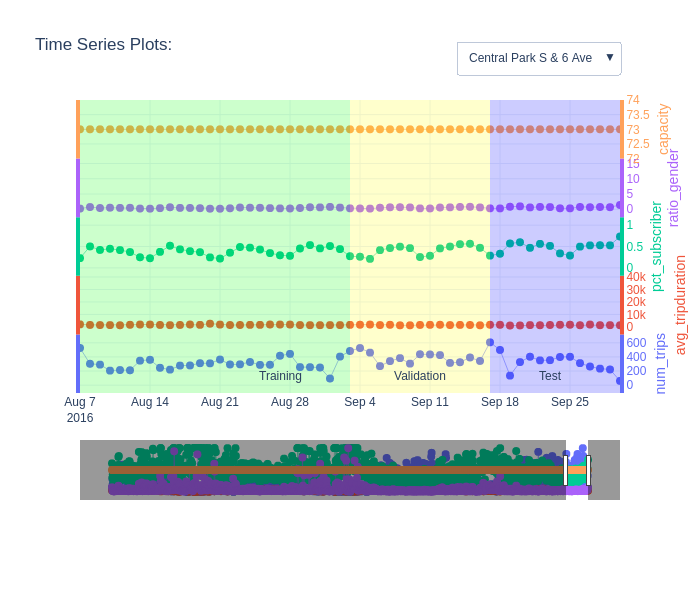

In [10]:
print('A Snapshot of the interactive plot:')
fig.show('png')

创建预测模型
参考[`model_type = 'ARIMA_PLUS_XREG'`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-multivariate-time-series)

使用BigQuery ML Arima+ XREG (`model_type = 'ARIMA_PLUS_XREG'`), 一个[BigQuery ML](https://cloud.google.com/bigquery/docs/e2e-journey)的特性。这种方法使用ARIMA进行单变量时间序列建模，同时自动化许多推断类型的任务：预处理、假日调整、高峰、低谷、异常值、季节性和趋势分解、突变调整、趋势建模、预测。这是来自BigQuery ML文档的流程图例:

<p><center>
    <img alt="ARIMA_PLUS_XREG Flowchart" src="https://cloud.google.com/static/bigquery/images/BQ_ARIMA_PLUS_XREG_diagram.png" width="75%">
</center><p>
    
更深入地了解ARIMA+流程:

<p><center>
    <img alt="ARIMA_PLUS Flowchart" src="https://cloud.google.com/static/bigquery/images/BQ_ARIMA_diagram.png" width="75%">
</center><p>

注意：使用where语句来预测单个站点。

（未来）在同一时间预测多个时间序列，每个个别站点在中央公园附近，使用`time_series_id_col >= `输入。

注意：ARIMA预测是单变量的，不使用验证数据，因此我们将其包含在训练数据中：

In [11]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       #time_series_id_col = '{SERIES_COLUMN}',
       data_frequency = '{FORECAST_GRANULARITY}',
       auto_arima_max_order = 5,
       holiday_region = ['GLOBAL', 'US'],
       horizon = {FORECAST_HORIZON_LENGTH} + {FORECAST_TEST_LENGTH}
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE {SPLIT_COLUMN} in ('TRAIN','VALIDATE')
        AND {SERIES_COLUMN} = '{chosen_station}'
"""
print(query)


    CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = 'starttime',
       time_series_data_col = 'num_trips',
       #time_series_id_col = 'start_station_name',
       data_frequency = 'DAILY',
       auto_arima_max_order = 5,
       holiday_region = ['GLOBAL', 'US'],
       horizon = 14 + 14
      ) AS
    SELECT starttime, num_trips,
        avg_tripduration, pct_subscriber, ratio_gender, capacity
    FROM `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
        AND start_station_name = 'Central Park S & 6 Ave'



In [12]:
job = bq.query(query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 33.76


In [13]:
print(f'Review The Model in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_arimaplusxreg&pli=1')

Review The Model in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-data_prepped_arimaplusxreg&pli=1


### 检视 ARIMA 系数
参考[`ML.ARIMA_COEFFICIENTS`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients)

In [14]:
query = f"""
    SELECT *
    FROM ML.ARIMA_COEFFICIENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
coefficients = bq.query(query).to_dataframe()
coefficients

ar_coefficients                                    ma_coefficients  \
0              []                                                 []   
1              []                                                 []   
2              []                                                 []   
3              []                                                 []   
4              []                                                 []   
5              []  [-0.6799177435713923, -0.4179312249870092, 0.7...   

   intercept_or_drift   processed_input        weight category_weights  
0                 NaN  avg_tripduration -1.513919e-03               []  
1                 NaN    pct_subscriber -3.021674e+02               []  
2                 NaN      ratio_gender  2.385852e+00               []  
3                 NaN          capacity  1.663402e+00               []  
4                 NaN     __INTERCEPT__ -3.435246e-11               []  
5                 0.0              None           NaN               []

### 回顾输入特征
参考[`ML.FEATURE_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-feature)。

In [15]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()

input      min           max         mean       median  \
0         num_trips    1.000    555.000000   144.153912   130.000000   
1         starttime      NaN           NaN          NaN          NaN   
2  avg_tripduration  336.625  34597.615385  1918.560216  1836.544000   
3    pct_subscriber    0.000      1.000000     0.497785     0.467290   
4      ratio_gender    0.000     14.000000     0.908012     0.555556   

        stddev  category_count  null_count  dimension  
0   112.409702            <NA>           0       <NA>  
1          NaN            1163           0       <NA>  
2  1334.905339            <NA>           0       <NA>  
3     0.214707            <NA>           0       <NA>  
4     1.329083            <NA>          26       <NA>

### 查看培训信息
参考[`ML.TRAINING_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train)

In [16]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
trainingInfo = bq.query(query).to_dataframe()
trainingInfo.head()

training_run  iteration  duration_ms
0             0          0         4376

预测评估

### 预测指标
参考[`ML.EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)中 `model_type = 'ARIMA_PLUS_XREG'`

返回的指标取决于是否提供输入（测试）数据以及`perform_aggregation`是`True`还是`False`。如果是`False`，则提供每个时间戳的指标，如果是`True`，则提供每个`time_series_id_col`的指标。

In [17]:
query = f"""
    SELECT *
    FROM ML.EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
                AND {SERIES_COLUMN} = '{chosen_station}'
        ),
        STRUCT(TRUE AS perform_aggregation))
"""
metrics = bq.query(query).to_dataframe()
metrics

mean_absolute_error  mean_squared_error  root_mean_squared_error  \
0            84.869258        12786.969584               113.079483   

   mean_absolute_percentage_error  symmetric_mean_absolute_percentage_error  
0                       36.418356                                 31.541218

### 评估时间序列模型
参考[`ML.ARIMA_EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-arima-evaluate)

模型评估指标表:
ARIMA术语:
- p = 自回归项的数量
- d = 需要实现平稳性的非季节性差分数量
- q = 滞后的预测误差数量 (移动平均部分)

In [18]:
query = f"""
    SELECT *
    FROM ML.ARIMA_EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT(FALSE as show_all_candidate_models))
"""
arima_metrics = bq.query(query).to_dataframe()
arima_metrics

non_seasonal_p  non_seasonal_d  non_seasonal_q  has_drift  log_likelihood  \
0               0               1               5      False    -5786.440397   

            AIC     variance  seasonal_periods  has_holiday_effect  \
0  11584.880793  1119.496349  [WEEKLY, YEARLY]                True   

   has_spikes_and_dips  has_step_changes error_message  
0                 True             False

### 模型中的假日效应
参考 [`ML.HOLIDAY_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-holiday-info)

被建模并检测到假日效应的假日列表：
- `region`，这些在 `CREATE MODEL` 语句中使用参数 `holiday_region` 指定
- `holiday_name` 是具有检测效应的假日名称
- `primary_date` 是假日的日历日期
- `preholiday_days` 和 `postholiday_days` 是在建模过程中考虑的假日周围的整数窗口

In [19]:
query = f"""
    SELECT *
    FROM ML.HOLIDAY_INFO(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
holiday_info = bq.query(query).to_dataframe()
holiday_info

region            holiday_name primary_date  preholiday_days  \
0     GLOBAL  AllSaintsDay-Halloween   2000-10-31                1   
1     GLOBAL  AllSaintsDay-Halloween   2001-10-31                1   
2     GLOBAL  AllSaintsDay-Halloween   2002-10-31                1   
3     GLOBAL  AllSaintsDay-Halloween   2003-10-31                1   
4     GLOBAL  AllSaintsDay-Halloween   2004-10-31                1   
...      ...                     ...          ...              ...   
1619      US              VeteranDay   2026-11-11                1   
1620      US              VeteranDay   2027-11-11                1   
1621      US              VeteranDay   2028-11-11                1   
1622      US              VeteranDay   2029-11-11                1   
1623      US              VeteranDay   2030-11-11                1   

      postholiday_days  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
...                ...  
1619                 1  
1620                 1  
1621                 1  
1622                 1  
1623                 1  

[1624 rows x 5 columns]

## 时间序列预测
参考[`ML.FORECAST`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-forecast)

计算每个时间戳的预测值，并在请求的置信水平下提供标准误差和预测区间。

默认的`horizon`为3，因此可能需要将此参数设置为训练时使用的大小。

**注意** 当使用外部回归变量时，它们的值需要用于计算预测。

In [20]:
query = f"""
    SELECT *
    FROM ML.FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
                AND {SERIES_COLUMN} = '{chosen_station}'
        )
        )
"""
forecast = bq.query(query).to_dataframe()
forecast

forecast_timestamp  forecast_value  standard_error  \
0  2016-09-17 00:00:00+00:00      358.241628       33.458879   
1  2016-09-18 00:00:00+00:00      491.458902       35.131070   
2  2016-09-19 00:00:00+00:00      332.215678       35.283290   
3  2016-09-20 00:00:00+00:00      165.155313       40.727100   
4  2016-09-21 00:00:00+00:00      248.723881       48.710074   
5  2016-09-22 00:00:00+00:00      260.924205       48.763952   
6  2016-09-23 00:00:00+00:00      278.543954       48.817770   
7  2016-09-24 00:00:00+00:00      324.208685       48.871529   
8  2016-09-25 00:00:00+00:00      380.716377       48.925230   
9  2016-09-26 00:00:00+00:00      304.342626       48.978871   
10 2016-09-27 00:00:00+00:00      224.258563       49.032453   
11 2016-09-28 00:00:00+00:00      249.681621       49.085977   
12 2016-09-29 00:00:00+00:00      207.089476       49.139443   
13 2016-09-30 00:00:00+00:00      138.935921       49.192851   

    confidence_level  prediction_interval_lower_bound  \
0               0.95                       292.780734   
1               0.95                       422.726436   
2               0.95                       263.185399   
3               0.95                        85.474449   
4               0.95                       153.424662   
5               0.95                       165.519576   
6               0.95                       183.034032   
7               0.95                       228.593586   
8               0.95                       284.996216   
9               0.95                       208.517518   
10              0.95                       128.328624   
11              0.95                       153.646964   
12              0.95                       110.950215   
13              0.95                        42.692170   

    prediction_interval_upper_bound  
0                        423.702522  
1                        560.191367  
2                        401.245957  
3                        244.836176  
4                        344.023099  
5                        356.328833  
6                        374.053875  
7                        419.823784  
8                        476.436538  
9                        400.167734  
10                       320.188503  
11                       345.716278  
12                       303.228736  
13                       235.179671

## 时间序列的预测+解释
参考[`ML.EXPLAIN_FORECAST`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-explain-forecast)

BigQuery ML具有增强的预测功能，还包括解释信息。

除了预测和相应的预测区间，还包括趋势、季节性、假日效应、高峰和低谷、阶跃变化的实际值和信息，以及外部回归器的归因。

**注意** 使用外部回归器时，需要其值来计算预测。

In [21]:
query = f"""
    SELECT '{chosen_station}' as {SERIES_COLUMN}, *, 
        EXTRACT(DATE FROM time_series_timestamp) AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({FORECAST_HORIZON_LENGTH + FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SERIES_COLUMN} = '{chosen_station}'
        )
        )
    ORDER BY {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()
explain.tail()

start_station_name     time_series_timestamp time_series_type  \
1197  Central Park S & 6 Ave 2016-10-10 00:00:00+00:00         forecast   
1198  Central Park S & 6 Ave 2016-10-11 00:00:00+00:00         forecast   
1199  Central Park S & 6 Ave 2016-10-12 00:00:00+00:00         forecast   
1200  Central Park S & 6 Ave 2016-10-13 00:00:00+00:00         forecast   
1201  Central Park S & 6 Ave 2016-10-14 00:00:00+00:00         forecast   

      time_series_data  time_series_adjusted_data  standard_error  \
1197        339.941712                 339.941712       49.723772   
1198        321.508342                 321.508342       49.776552   
1199        236.370046                 236.370046       49.829277   
1200        229.267657                 229.267657       49.881946   
1201        270.542683                 270.542683       49.934560   

      confidence_level  prediction_interval_lower_bound  \
1197              0.95                       242.659237   
1198              0.95                       224.122603   
1199              0.95                       138.881154   
1200              0.95                       131.675720   
1201              0.95                       172.847810   

      prediction_interval_upper_bound       trend  ...  \
1197                       437.224188  269.605108  ...   
1198                       418.894080  269.605108  ...   
1199                       333.858938  269.605108  ...   
1200                       326.859594  269.605108  ...   
1201                       368.237556  269.605108  ...   

      holiday_effect_VeteranDay  holiday_effect_WhitMonday  \
1197                        0.0                        0.0   
1198                        0.0                        0.0   
1199                        0.0                        0.0   
1200                        0.0                        0.0   
1201                        0.0                        0.0   

      holiday_effect_Halloween  holiday_effect_US_ColumbusDay  \
1197                       0.0                            0.0   
1198                       0.0                            0.0   
1199                       0.0                            0.0   
1200                       0.0                            0.0   
1201                       0.0                            0.0   

      attribution_avg_tripduration  attribution_pct_subscriber  \
1197                     -2.904546                 -150.414332   
1198                     -2.904546                 -150.414332   
1199                     -2.904546                 -150.414332   
1200                     -2.904546                 -150.414332   
1201                     -2.904546                 -150.414332   

      attribution_ratio_gender  attribution_capacity  \
1197                  2.166382            121.428342   
1198                  2.166382            121.428342   
1199                  2.166382            121.428342   
1200                  2.166382            121.428342   
1201                  2.166382            121.428342   

      attribution___INTERCEPT__   starttime  
1197              -3.435246e-11  2016-10-10  
1198              -3.435246e-11  2016-10-11  
1199              -3.435246e-11  2016-10-12  
1200              -3.435246e-11  2016-10-13  
1201              -3.435246e-11  2016-10-14  

[5 rows x 61 columns]

### 使用预测可视化时间序列

In [22]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast prediction funnel to test and horizon: lower
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    name = f'Lower Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast prediction funnel to test and horizon: upper
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    name = f'Upper Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    fillcolor = 'rgba(0,128,0,0.5)',
                    fill = 'tonexty',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    name = f'Forecast: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 3 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


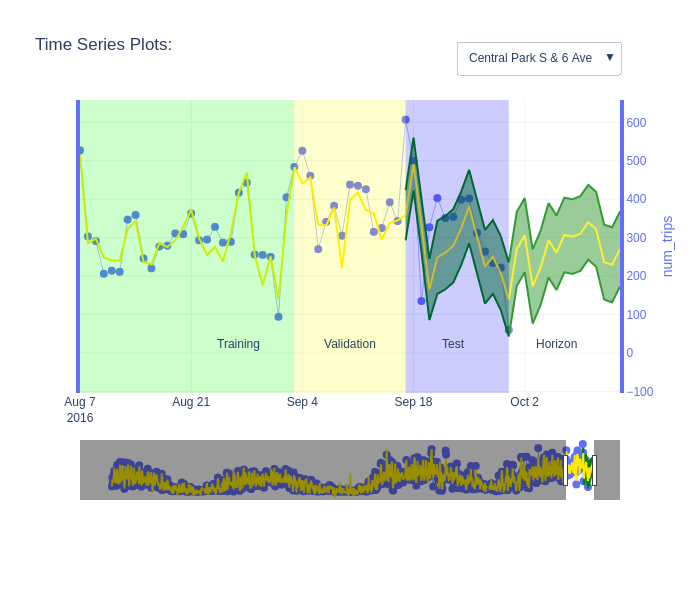

In [23]:
print('A Snapshot of the interactive plot:')
fig.show('png')

使用SQL计算指标

一些用于评估预测有效性的常见指标包括
- MAPE，或平均绝对百分比误差
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE，或平均绝对误差
    - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- 将MAE除以平均需求以得到类似MAPE的百分比
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE，或均方误差
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE，或均方根误差
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- 将RMSE除以平均需求以得到类似MAPE的百分比
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

显式计算这些指标可以有助于公平比较不同数据集和模型之间的表现。这部分展示了如何使用SQL进行计算。

> ```sql
> (actual_value - forecast_value) as diff
>
> AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
> AVG(ABS(diff)) as MAE,
> SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
> AVG(POW(diff, 2)) as MSE,
> SQRT(AVG(POW(diff, 2))) as RMSE,
> SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
> ```

In [24]:
query = f"""
    WITH    
        FORECAST AS (
            SELECT
                '{chosen_station}' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                    WHERE {SPLIT_COLUMN} = 'TEST'
                        AND {SERIES_COLUMN} = '{chosen_station}'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST' AND {SERIES_COLUMN} = '{chosen_station}'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT {SERIES_COLUMN}, time_series_type, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}, time_series_type
    ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)

start_station_name time_series_type      MAPE        MAE     pMAE  \
0  Central Park S & 6 Ave         forecast  0.364184  84.869258  0.26005   

            MSE        RMSE    pRMSE  
0  12786.969584  113.079483  0.34649

总体指标:

In [25]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                '{chosen_station}' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                    WHERE splits = 'TEST'
                        AND {SERIES_COLUMN} = '{chosen_station}'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
        AVG(ABS(diff)) as MAE,
        SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

time_series_type      MAPE        MAE     pMAE           MSE        RMSE  \
0         forecast  0.364184  84.869258  0.26005  12786.969584  113.079483   

     pRMSE  
0  0.34649

异常检测
参考[`ML.DETECT_ANOMALIES`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies)

**注意** 目前（2023年7月），`ARIMA_PLUS_XREG`尚未使用`ML.DETECT_ANOMALIES`函数。一旦该功能发布，本节将会更新。

删除资源

要删除在BigQuery中创建的模型，请取消注释`bq.delete_model`语句，并运行下面的单元格：

In [26]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg')
#bq.delete_model(model)

目前（2023年7月），[`model_type = 'ARIMA_PLUS_XREG'`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-multivariate-time-series) 可以拟合单个时间序列。将来它将能够拟合多个时间序列，类似于 [`model_type = 'ARIMA_PLUS'`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series)，通过使用参数 `time_series_id_col` 来指定多个时间序列。解决方法是编写 SQL，以创建多个时间序列模型的单个查询。

获取时间序列列表，并使用[ROW_NUMBER()](https://cloud.google.com/bigquery/docs/reference/standard-sql/numbering_functions#row_number)函数为不同的序列创建整数ID：

In [57]:
query = f"""
SELECT ROW_NUMBER() OVER (ORDER BY {SERIES_COLUMN}) AS row_number, *
FROM
    (SELECT DISTINCT {SERIES_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`)
"""
timeseries = bq.query(query).to_dataframe()
timeseries

row_number                             start_station_name
0            1  Central Park North & Adam Clayton Powell Blvd
1            2                         Central Park S & 6 Ave
2            3                       Central Park W & W 96 St
3            4                   Central Park West & W 100 St
4            5                   Central Park West & W 102 St
5            6                    Central Park West & W 68 St
6            7                    Central Park West & W 72 St
7            8                    Central Park West & W 76 St
8            9                    Central Park West & W 85 St
9           10              Grand Army Plaza & Central Park S
10          11                   W 106 St & Central Park West
11          12                    W 82 St & Central Park West

方法1：过程化语言

BigQuery专用语言中的[EXECUTE IMMEDIATE](https://cloud.google.com/bigquery/docs/reference/standard-sql/procedural-language#execute_immediate)语句可用于创建动态SQL。将其与[FOR…IN](https://cloud.google.com/bigquery/docs/reference/standard-sql/procedural-language#for-in)循环结合使用可以按顺序创建多个时间序列。

In [53]:
# relisting covariate columns without capacity, because some time series have all null values for capacity:
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender']

In [54]:
query = f"""
    FOR id IN (
        SELECT ROW_NUMBER() OVER (ORDER BY {SERIES_COLUMN}) AS row_number, *
        FROM
            (SELECT DISTINCT {SERIES_COLUMN}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`)    
    ) DO
    EXECUTE IMMEDIATE
        CONCAT("CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_", id.row_number, "` OPTIONS (model_type = 'ARIMA_PLUS_XREG', time_series_timestamp_col = '{TIME_COLUMN}', time_series_data_col = '{TARGET_COLUMN}', data_frequency = '{FORECAST_GRANULARITY}', auto_arima_max_order = 5, holiday_region = ['GLOBAL', 'US'], horizon = {FORECAST_HORIZON_LENGTH} + {FORECAST_TEST_LENGTH}) AS SELECT {TIME_COLUMN}, {TARGET_COLUMN}, {', '.join(COVARIATE_COLUMNS)} FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE {SPLIT_COLUMN} in ('TRAIN','VALIDATE') AND {SERIES_COLUMN} = '", id.{SERIES_COLUMN}, "'");
    END FOR;
"""
print(query)


    FOR id IN (
        SELECT ROW_NUMBER() OVER (ORDER BY start_station_name) AS row_number, *
        FROM
            (SELECT DISTINCT start_station_name
            FROM `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped`)    
    ) DO
    EXECUTE IMMEDIATE
        CONCAT("CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped_arimaplusxreg_", id.row_number, "` OPTIONS (model_type = 'ARIMA_PLUS_XREG', time_series_timestamp_col = 'starttime', time_series_data_col = 'num_trips', data_frequency = 'DAILY', auto_arima_max_order = 5, holiday_region = ['GLOBAL', 'US'], horizon = 14 + 14) AS SELECT starttime, num_trips, avg_tripduration, pct_subscriber, ratio_gender FROM `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped` WHERE splits in ('TRAIN','VALIDATE') AND start_station_name = '", id.start_station_name, "'");
    END FOR;



In [55]:
job = bq.query(query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 298.503


方法二：带有异步作业的Python客户端

另一种方法是使用客户端，在这种情况下是BigQuery的Python客户端，为每个时间序列提交单独的查询并异步管理它们。如果项目中有资源可用，这可能导致更快的执行总时间。

In [63]:
timeseries = list(timeseries.itertuples(index = False, name = None))
timeseries

[(1, 'Central Park North & Adam Clayton Powell Blvd'),
 (2, 'Central Park S & 6 Ave'),
 (3, 'Central Park W & W 96 St'),
 (4, 'Central Park West & W 100 St'),
 (5, 'Central Park West & W 102 St'),
 (6, 'Central Park West & W 68 St'),
 (7, 'Central Park West & W 72 St'),
 (8, 'Central Park West & W 76 St'),
 (9, 'Central Park West & W 85 St'),
 (10, 'Grand Army Plaza & Central Park S'),
 (11, 'W 106 St & Central Park West'),
 (12, 'W 82 St & Central Park West')]

In [60]:
def make_model(ts):
    query = f"""
        # create a model for {SERIES_COLUMN} = '{ts[1]}'
        CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{ts[0]}`
        OPTIONS
          (model_type = 'ARIMA_PLUS_XREG',
           time_series_timestamp_col = '{TIME_COLUMN}',
           time_series_data_col = '{TARGET_COLUMN}',
           #time_series_id_col = '{SERIES_COLUMN}',
           data_frequency = '{FORECAST_GRANULARITY}',
           auto_arima_max_order = 5,
           holiday_region = ['GLOBAL', 'US'],
           horizon = {FORECAST_HORIZON_LENGTH} + {FORECAST_TEST_LENGTH}
          ) AS
        SELECT {TIME_COLUMN}, {TARGET_COLUMN},
            {', '.join(COVARIATE_COLUMNS)}
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE {SPLIT_COLUMN} in ('TRAIN','VALIDATE')
            AND {SERIES_COLUMN} = '{ts[1]}'
    """
    return query

In [64]:
print(make_model(timeseries[0]))


        # create a model for start_station_name = 'Central Park North & Adam Clayton Powell Blvd'
        CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped_arimaplusxreg_1`
        OPTIONS
          (model_type = 'ARIMA_PLUS_XREG',
           time_series_timestamp_col = 'starttime',
           time_series_data_col = 'num_trips',
           #time_series_id_col = 'start_station_name',
           data_frequency = 'DAILY',
           auto_arima_max_order = 5,
           holiday_region = ['GLOBAL', 'US'],
           horizon = 14 + 14
          ) AS
        SELECT starttime, num_trips,
            avg_tripduration, pct_subscriber, ratio_gender
        FROM `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped`
        WHERE splits in ('TRAIN','VALIDATE')
            AND start_station_name = 'Central Park North & Adam Clayton Powell Blvd'
    


In [67]:
from time import sleep

In [68]:
bqml_jobs = [bq.query(query = make_model(ts)) for ts in timeseries]

while not all([job.done() for job in bqml_jobs]):
    print('waiting on all jobs to finish ... sleeping for 5s')
    sleep(5)
for j, job in enumerate(bqml_jobs):
    print('Completed with Errors = ', job.error_result)

waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
Completed with Errors =  None
Completed with Errors =  None
Completed with Errors =  None
Completed with Errors =  None
Completed with Errors =  None
Completed with Errors =  None
Completed with Errors =  None
Completed with Errors =  None
Completed with Errors =  None
Completed with Errors =  None
Completed with Errors =  None
Completed with Errors =  None


## 使用多个模型工作

使用模型的函数需要跨所有单独的模型使用函数，并组合结果。以下是一个示例。这使用Python构建查询，将所有单独的模型结果合并为一个输出集。

In [79]:
query = ""
for t, ts in enumerate(timeseries):
    query += f"""
        SELECT '{ts[1]}' as {SERIES_COLUMN}, *
        FROM ML.EVALUATE(
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{ts[0]}`,
            (
                SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                    {', '.join(COVARIATE_COLUMNS)}
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                WHERE {SPLIT_COLUMN} = 'TEST'
                    AND {SERIES_COLUMN} = '{chosen_station}'
            ),
            STRUCT(TRUE AS perform_aggregation)
        )
    """
    if t < len(timeseries)-1: query += "UNION ALL"

In [80]:
#print(query)

In [81]:
metrics = bq.query(query).to_dataframe()
metrics

start_station_name  mean_absolute_error  \
0                     Central Park West & W 85 St           171.290795   
1                     W 82 St & Central Park West           238.753145   
2                    Central Park West & W 102 St           260.029256   
3                          Central Park S & 6 Ave            84.885617   
4                    W 106 St & Central Park West           241.481703   
5                        Central Park W & W 96 St           202.442318   
6                     Central Park West & W 76 St           214.290854   
7                     Central Park West & W 72 St           121.883951   
8                    Central Park West & W 100 St           257.895012   
9               Grand Army Plaza & Central Park S           119.004419   
10  Central Park North & Adam Clayton Powell Blvd           200.693028   
11                    Central Park West & W 68 St           154.101324   

    mean_squared_error  root_mean_squared_error  \
0         40369.753440               200.922257   
1         72013.375008               268.353079   
2         83697.364612               289.304968   
3         12792.523379               113.104038   
4         73739.378699               271.549956   
5         53031.090207               230.284802   
6         57026.501450               238.802222   
7         22554.630553               150.181991   
8         83302.784732               288.622218   
9         19427.657590               139.383132   
10        47953.942385               218.983886   
11        33857.047915               184.002848   

    mean_absolute_percentage_error  symmetric_mean_absolute_percentage_error  
0                        47.732383                                 63.836655  
1                        67.112579                                105.230112  
2                        74.224959                                122.457784  
3                        36.419940                                 31.547787  
4                        68.005365                                107.471750  
5                        56.376148                                 81.270972  
6                        62.764186                                 90.689374  
7                        41.739618                                 42.696262  
8                        72.864692                                119.704992  
9                        41.644377                                 41.804210  
10                       64.146976                                 93.515945  
11                       48.928761                                 56.025046